In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Dropout,LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [122]:
import pandas as pd

rows = []
with open("/content/twitter_training.csv", encoding="latin-1", errors="ignore") as f:
    for line in f:
        parts = line.strip().split(",", 3)   # split only 3 times
        if len(parts) == 4:
            rows.append(parts)

df = pd.DataFrame(rows, columns=["ID", "Game", "Sentiment", "Text"])
df.head()

,ID,Game,Sentiment,Text
0,2401,Borderlands,Positive,"""im getting on borderlands and i will murder y..."
1,2401,Borderlands,Positive,"""I am coming to the borders and I will kill yo..."
2,2401,Borderlands,Positive,"""im getting on borderlands and i will kill you..."
3,2401,Borderlands,Positive,"""im coming on borderlands and i will murder yo..."
4,2401,Borderlands,Positive,"""im getting on borderlands 2 and i will murder..."


In [123]:
df.shape

(74685, 4)

In [124]:
df.isnull().sum()

,0
ID,0
Game,0
Sentiment,0
Text,0


In [125]:
df['Text'][66]

"Going to finish up Borderlands 2 today. I've got some new commands set up and am looking forward to a good stream! Starting in about am hour!"

In [126]:
df['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant', '>'], dtype=object)

In [127]:
len(df[df['Sentiment']=='>'])

3

In [128]:
df = df[df['Sentiment'] != '>']

In [129]:
len(df[df['Sentiment']=='>'])

0

In [130]:
# normalization
df['Text']=df['Text'].str.lower()

In [131]:
# remove html tags
def remove_html_tags(text):
    pattern=re.compile('<.*?>')
    return pattern.sub(r'', text)

df['Text']=df['Text'].apply(remove_html_tags)


In [132]:
# remove urls
def remove_url(text):
    pattern=re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

df['Text']=df['Text'].apply(remove_url)

In [133]:
# remove punctutation
exclude=string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('','',exclude))

df['Text']=df['Text'].apply(remove_punc)

In [134]:
# remove stopwords
def remove_stopwords(text):
    new_text=[]
    for w in text.split():
        if w in stopwords.words('english'):
            new_text.append('')
        else:
            new_text.append(w)
    x=new_text[:]
    new_text.clear()
    return " ".join(x)

df['Text']=df['Text'].apply(remove_stopwords)

In [135]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def stem_func(text):
    words = text.split()                      # split into words
    stemmed = [porter.stem(w) for w in words] # stem each word
    return " ".join(stemmed)                  # join back into a string

df['Text']=df['Text'].apply(stem_func)

In [136]:
# isalnum
def remove_alnum(text):
    tokens = text.split()
    words=[word for word in tokens if word.isalnum()]
    return " ".join(words)

df['Text']=df['Text'].apply(remove_alnum)

In [137]:
df['Text'][66]

'go finish borderland 2 today ive got new command set look forward good stream start hour'

In [138]:
df.head()

,ID,Game,Sentiment,Text
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland 2 murder


In [139]:
df['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [140]:
# prepare data
texts=df['Text'].values
labels=df['Sentiment'].astype('category').cat.codes #convert to numeric
num_classes=len(df['Sentiment'].unique())

In [141]:
num_classes

4

In [142]:
texts

array(['im get borderland murder', 'come border kill',
       'im get borderland kill', ...,
       'realiz window partit mac 6 year behind nvidia driver idea notic',
       'realiz window partit mac like 6 year behind nvidia driver car fuck idea ever notic',
       'like window partit mac like 6 year behind driver idea notic'],
      dtype=object)

In [143]:
# train test split
X_train, X_test, y_train, y_test=train_test_split(texts,
                                                 labels,
                                                 test_size=0.2,
                                                 random_state=42)

In [144]:
# tokenization
MAX_WORDS=10000 #max num of unique words
MAX_LEN=200 #max sequence length

tokenizer=Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>") #Out of vocab
tokenizer.fit_on_texts(X_train)

X_train_seq=tokenizer.texts_to_sequences(X_train)
X_test_seq=tokenizer.texts_to_sequences(X_test)

X_train_pad=pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad=pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

y_train_cat=to_categorical(y_train, num_classes=num_classes)
y_test_cat=to_categorical(y_test, num_classes=num_classes)

In [169]:
# Build BiLSTM model
# model=Sequential()
# model.add(Embedding(input_dim=MAX_WORDS, output_dim=128, input_shape=(MAX_LEN,)))
# model.add(Bidirectional(LSTM(64, return_sequences=False)))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# M-2
from tensorflow.keras.regularizers import l2

model=Sequential()
model.add(Embedding(MAX_WORDS, 128, input_shape=(MAX_LEN,)))
model.add(Bidirectional(LSTM(32, return_sequences=False,
                             kernel_regularizer=l2(0.001),
                            #  recurrent_regularizer=l2(0.001)
                            )))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# M-3
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.layers import GlobalAveragePooling1D

# model=Sequential()
# model.add(Embedding(MAX_WORDS, 128, input_shape=(MAX_LEN,)))
# model.add(Bidirectional(LSTM(32, return_sequences=False,
#                              dropout=0.5,             # input dropout
#                              recurrent_dropout=0.5,   # recurrent dropout
#                              kernel_regularizer=l2(0.001),
#                             #  recurrent_regularizer=l2(0.001)
#                             )))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,636 (5.06 MB)

 Trainable params: 1,325,636 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

In [170]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [171]:
history=model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=[es]
)

Epoch 1/20
934/934 ━━━━━━━━━━━━━━━━━━━━ 59s 21ms/step - accuracy: 0.4569 - loss: 1.3152 - val_accuracy: 0.6762 - val_loss: 0.8830
Epoch 2/20
934/934 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.7228 - loss: 0.7961 - val_accuracy: 0.7294 - val_loss: 0.7450
Epoch 3/20
934/934 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7838 - loss: 0.6486 - val_accuracy: 0.7471 - val_loss: 0.7080
Epoch 4/20
934/934 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8176 - loss: 0.5557 - val_accuracy: 0.7699 - val_loss: 0.6588
Epoch 5/20
934/934 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8370 - loss: 0.5037 - val_accuracy: 0.7878 - val_loss: 0.6220
Epoch 6/20
934/934 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.8522 - loss: 0.4644 - val_accuracy: 0.7909 - val_loss: 0.6219
Epoch 7/20
934/934 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8621 - loss: 0.4340 - val_accuracy: 0.7995 - val_loss: 0.5942
Epoch 8/20
934/934 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8713 - loss: 0.4036 - 

In [172]:
# evaluate
loss, acc=model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

Test Accuracy: 0.8160
Test Loss: 0.5917


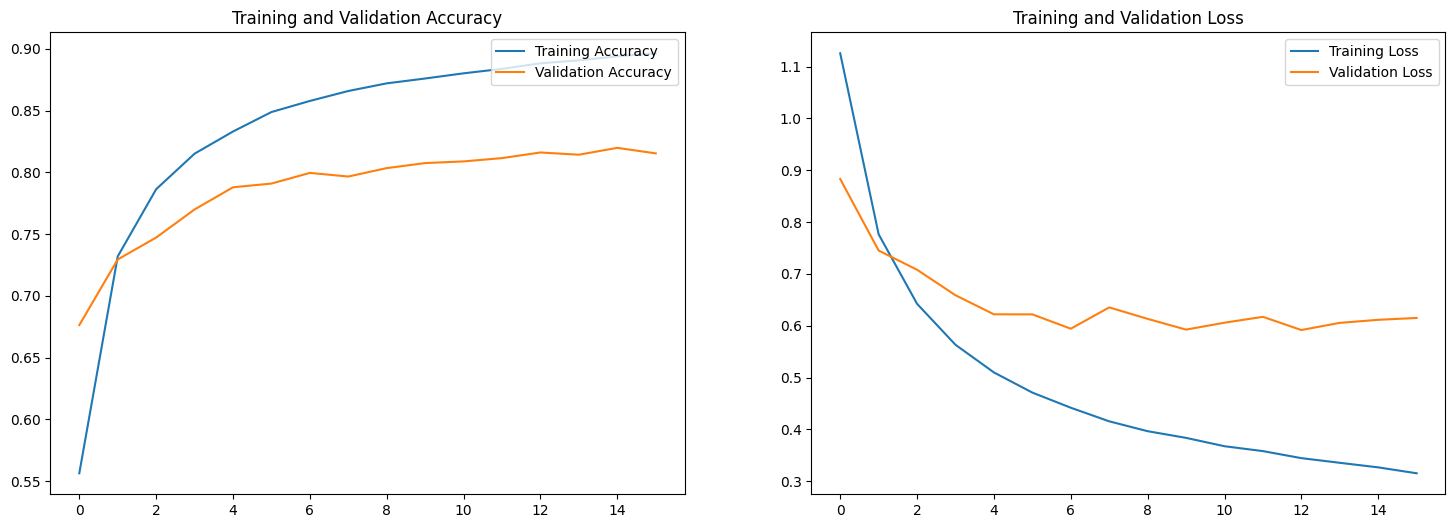

In [173]:
import matplotlib.pyplot as plt

# Plot accuracy and  loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()